In [ ]:
#preprocess with transform
#NO opencv!!!!!!!!!!
#resnet + ensemble

# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = "mango_class/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/mango_class


In [ ]:
import lightgbm as lgb

In [ ]:
import os
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image#https://yungyuc.github.io/oldtech/python/python_imaging.html
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image#https://yungyuc.github.io/oldtech/python/python_imaging.html
import torch.optim as optim
from torch.optim import lr_scheduler


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

import torchvision.models as models
import torch.nn as nn
from sklearn.svm import LinearSVC as svm
from sklearn.model_selection import cross_validate
from sklearn.externals import joblib
from collections import Counter
import time
from py_files.dataloader2 import *

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
import torch
USE_GPU = True

# dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)


using device: cuda


In [ ]:
inp = torch.zeros([128, 3, 224, 224])

In [ ]:
model1 = models.resnet18(pretrained=True)
model1 = nn.Sequential(*list(model1.children())[:-2])
for param in model1.parameters():
    param.requires_grad = False
model1.fc = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
)
print(model1(inp).size())#([128, 512, 7, 7])



Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



torch.Size([128, 512, 1, 1])


In [ ]:
# model1 = models.resnet18(pretrained=True)
# for param in model1.parameters():
#     param.requires_grad = False
# # 替换最后的全连接层， 改为训练100类
# # 新构造的模块的参数默认requires_grad为True
# model1.fc = nn.Sequential(
#     nn.Dropout(p = 0.5),
#     nn.Linear(512, 3),
#     # nn.PReLU(num_parameters=1, init=0.25),
#     # nn.Dropout(p = 0.5),
#     # nn.Linear(64, 3),
#     # nn.Softmax(dim=1),
# )
model1 = models.resnet152(pretrained=True)
model1 = nn.Sequential(*list(model1.children())[:-2])
for param in model1.parameters():
    param.requires_grad = False
model1.fc = nn.Sequential(
    
    nn.AdaptiveAvgPool2d((1, 1)),

    nn.Flatten(),
    nn.Dropout(p = 0.6),
    nn.Linear(2048, 3),
)
model1 = model1.to(device)
################################################################################
model2 = models.vgg11(pretrained=True)
model2 = model2.features[0:39]

for param in model2.parameters():
    param.requires_grad = False
# model[0][0] = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model2.fc = nn.Sequential(
   
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    # nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    nn.AdaptiveAvgPool2d(output_size=(7, 7)),

    nn.Flatten(),
    # nn.Dropout(p=0.6, inplace=False),
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),

    nn.Dropout(p=0.6, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    
    nn.Dropout(p=0.6, inplace=False),
    nn.Linear(in_features=4096, out_features=3, bias=True),

    )

model2 = model2.to(device)
################################################################################
model3 = models.googlenet(pretrained=True)
model3.dropout = nn.Dropout(p = 0.25, inplace=False)
for param in model3.parameters():
    param.requires_grad = False
# 替换最后的全连接层， 改为训练100类
# 新构造的模块的参数默认requires_grad为True
model3.fc = nn.Sequential(
    
    nn.Linear(in_features=1024, out_features=3, bias=True),
    # nn.Linear(in_features=1000, out_features=3, bias=True),
)
model3 = model3.to(device)
################################################################################
model4 = models.densenet121(pretrained=True)
for param in model4.parameters():
    param.requires_grad = False
# 替换最后的全连接层， 改为训练100类
# 新构造的模块的参数默认requires_grad为True
model4.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1024, out_features=1024, bias=True),
    nn.ReLU(inplace=True),

    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1024, out_features=3, bias=True),

)
model4 = model4.to(device)
# model.to(device)
# # weight_size = torch.load("model_params/batch1_resnet18.pth")['1.weight'].size()
# # weight = torch.zeros(*weight_size).to(device)
# # bias_size = torch.load("model_params/batch1_resnet18.pth")['1.bias'].size()
# # bias = torch.zeros(*bias_size).to(device)
# # # print(init)
# # # path = './model_params/batch' + str(i) + '_resnet18.pth'
# path = './model_params'
# # # files = os.listdir(path)
# # # print(files)
# # for i in range(1,8):
# #   weight_tensor = torch.load( path + "/batch" + str(i) + "_resnet18.pth")["1.weight"]
# #   weight += weight_tensor
# #   bias_tensor = torch.load( path + "/batch" + str(i) + "_resnet18.pth")["1.bias"]
# #   bias += bias_tensor

# # # print(bias)

# # weight /= 7
# # bias /= 7
# # li = [weight, bias]
# # for i,pa in enumerate(model.fc[1].parameters()):
# #   pa = li[i]

  
# # torch.save(model.fc.state_dict(), "model_params/batch_all_resnet18.pth")


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/checkpoints/vgg11-bbd30ac9.pth


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [ ]:
dataloaders = {"dev":None}
dataset_sizes = {"dev":None}
devset = mango(
    pic_root='/C1-P1_Train_Dev_fixed_nobatch/C1-P1_Dev/C1-P1_Dev_all',
    label_root = '/C1-P1_Train_Dev_fixed_nobatch/dev.csv',
    preload=True,
    phase = "dev"
)#把traning的dataset載下來



In [ ]:
batch_size = 128

devset_loader = DataLoader(devset, batch_size=batch_size
                            , shuffle=False, num_workers=4)

# Use the torch dataloader to iterate through the dataset

# dataloaders.update(train = trainset_loader)
dataloaders.update(dev = devset_loader)
# dataset_sizes.update(train = len(trainset_loader))
dataset_sizes.update(dev = len(devset_loader))

In [ ]:
def test_model(loader, model, num_model, which_net):
  scores_true = torch.zeros([0, 3]).to(device)
  labels = torch.zeros(0, dtype = torch.long).to(device)
  if num_model == 2:
    model.fc.load_state_dict(torch.load("model_params/nobatch" + str(num_model) + "_" + which_net + "_try.pth"))
  elif num_model % 2 == 1:
    model.fc.load_state_dict(torch.load("model_params/nobatch" + str(num_model) + "_" + which_net + "_try.pth"))
  elif num_model == 4:
    model.classifier.load_state_dict(torch.load("model_params/nobatch" + str(num_model) + "_" + which_net + "_try.pth"))
  # try:
  # model.fc.load_state_dict(torch.load("model_params/nobatch" + str(num_model) + "_" + which_net + ".pth"))
  # except:
  
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
      for x, y in loader:
          x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
          y = y.to(device=device, dtype=torch.long)
          scores = model(x)
          scores_true = torch.cat((scores_true, scores), 0)
          # np.vstack([y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7])
          labels = torch.cat((labels, y), 0)
          # print(y.size())
          _, preds = scores.max(1)
          num_correct += (preds == y).sum()
          num_samples += preds.size(0)
      acc = float(num_correct) / num_samples
      print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return scores_true, labels


In [ ]:
scores_init1 = torch.zeros([800,3]).to(device)
labels_init1 = torch.zeros([800]).to(device)
scores_model1, labels1 = test_model(devset_loader, model1, 1, "resnet152")
scores_init1 += scores_model1
  # print(labels)
# print(labels)
_, preds1 = torch.max(scores_init1,1)
# print(preds)
p1 = (preds1 == labels1).sum().item()/800
print(p1)


Got 450 / 800 correct (56.25)
0.5625


In [ ]:
scores_init2 = torch.zeros([800,3]).to(device)
labels_init2 = torch.zeros([800]).to(device)
scores_model2, labels2 = test_model(devset_loader, model2, 2, "vgg16")
scores_init2 += scores_model2
  # print(labels)
# print(labels)
_, preds2 = torch.max(scores_init2,1)
# print(preds)
p2 = (preds2 == labels2).sum().item()/800
print(p2)


Got 539 / 800 correct (67.38)
0.67375


In [ ]:
scores_init3 = torch.zeros([800,3]).to(device)
labels_init3 = torch.zeros([800]).to(device)
scores_model3, labels3 = test_model(devset_loader, model3, 3, "googlenet")
scores_init3 += scores_model3
  # print(labels)
# print(labels)
_, preds3 = torch.max(scores_init3,1)
# print(preds)
p3 = (preds3 == labels3).sum().item()/800
print(p3)
#dataloader1 is suitable 0.6462

Got 509 / 800 correct (63.62)
0.63625


In [ ]:
scores_init4 = torch.zeros([800,3]).to(device)
labels_init4 = torch.zeros([800]).to(device)
scores_model4, labels4 = test_model(devset_loader, model4, 4, "densenet121")
scores_init4 += scores_model4
  # print(labels)
# print(labels)
_, preds4 = torch.max(scores_init4,1)
# print(preds)
p4 = (preds4 == labels4).sum().item()/800
print(p4)


Got 457 / 800 correct (57.12)
0.57125


In [ ]:
scores_init1 = scores_init1.cpu()
S1 = np.exp(scores_init1).sum(dim=1).view(-1,1)
exp_s1 = np.exp(scores_init1)/torch.cat((S1, S1, S1), dim = 1)

scores_init2 = scores_init2.cpu()
S2 = np.exp(scores_init2).sum(dim=1).view(-1,1)
exp_s2 = np.exp(scores_init2)/torch.cat((S2, S2, S2), dim = 1)

scores_init3 = scores_init3.cpu()
S3 = np.exp(scores_init3).sum(dim=1).view(-1,1)
exp_s3 = np.exp(scores_init3)/torch.cat((S3, S3, S3), dim = 1)

scores_init4 = scores_init4.cpu()
S4 = np.exp(scores_init4).sum(dim=1).view(-1,1)
exp_s4 = np.exp(scores_init4)/torch.cat((S4, S4, S4), dim = 1)


In [ ]:
# mix_score = exp_s1 + exp_s2 + exp_s3 + exp_s4
mix_score = p1 * exp_s1 + p2 * exp_s2 + p3 * exp_s3 + p4 * exp_s4

In [ ]:
_, preds = torch.max(mix_score.to(device),1)
mix_p = ( preds == labels1).sum().item()/800

In [ ]:
print(mix_p)

0.66875


In [ ]:
cm = torch.zeros([3, 3])

for i, j in zip(labels1, preds):
  cm[i.item(), j.item()] += 1

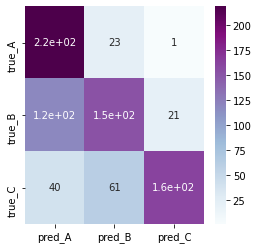

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(cm.numpy().astype(np.int32),
                     index = [i for i in ["true_A", "true_B", "true_C"]],
                     columns = [i for i in ["pred_A", "pred_B", "pred_C"]])
plt.figure(figsize = (4, 4))
sn.heatmap(df_cm, annot=True, cmap="BuPu")

In [ ]:
cm.numpy().astype(np.int32)

array([[219,  23,   1],
       [119, 153,  21],
       [ 40,  61, 163]], dtype=int32)

In [ ]:
測試model1的acc

NameError: ignored

In [ ]:
print(preds1)

tensor([2, 0, 0, 1, 2, 2, 1, 0, 1, 1, 2, 0, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, 0, 0, 0,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 2, 2, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1, 1, 2, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 1, 2, 0, 1,
        0, 1, 0, 2, 1, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        2, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 1,
        0, 0, 0, 1, 2, 2, 0, 2, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0,
        0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 2,